# 自动微分
- 自动微分(automatic differentiation)：深度学习框架中自动计算导数的方法
- 计算图(computational graph)：跟踪计算是哪些数据通过哪些组合操作产生输出
- 反向传播(backpropagate)：跟踪整个computational graph，填充关于每个参数的偏导数
  
  实际中，根据设计好的模型，系统会构建一个computational graph，并且自动微分使系统能够随后反向传播梯度

## 例子
对于函数$y=2\mathbf{X}^\top \mathbf{X}$关于列向量$\mathbf{X}$求导

In [2]:
# 创建X并为其分配初始值
import torch
x=torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [3]:
# 需要一个地方存储梯度，并且要在原地更改
# 等价于x=torch.arange(4.0,requires_grad=True)  
x.requires_grad_(True) 
x.grad

In [4]:
# 计算y
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
# 计算并打印梯度
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [6]:
x.grad==4*x

tensor([True, True, True, True])

In [7]:
# 默认pytroch会积累梯度，需要清零
x.grad.zero_()
y=x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 非scalar变量的backpropogation
- 当y不是scalar时，向量y关于向量x的导数是一个矩阵。对于高阶和高维的y和x，求导的结果可以是一个高阶tensor，即雅可比矩阵(Jacobian matrix)  
    input: $ X_{n\times 1}=\begin{bmatrix}x_1\\x_2\\\vdots\\x_n\end{bmatrix}$,output: $ Y_{m\times 1}=\begin{bmatrix}y_1\\y_2\\y_3\\\vdots\\y_m\end{bmatrix}，其中每个y_i都是x_1,x_2,\cdots,x_n的函数，即y_i=f(x_1,x_2,\cdots,x_n)$  
    则$Y关于X的Jacobian matrix是m\times n的矩阵，且J_{ij}=\frac{\partial y_i}{\partial x_j}$
    $$
    \Rightarrow 
    \mathbf{J}=\begin{bmatrix}
    \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \cdots & \frac{\partial y_1}{\partial x_n}\\
    \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \cdots & \frac{\partial y_2}{\partial x_n}\\
    \vdots & \vdots & \ddots & \vdots\\
    \frac{\partial y_m}{\partial x_1} & \frac{\partial y_m}{\partial x_2} & \cdots & \frac{\partial y_m}{\partial x_n}
    \end{bmatrix}
    $$  

    以下面公式为例:  
    $$
    y=x \odot x=\begin{bmatrix}x_1^2&x_2^2&x_3^2&x_4^2\end{bmatrix}^\top
    \Rightarrow
    \mathbf{J}=\begin{bmatrix}
    2x_1 & 0 & 0 & 0\\
    0 & 2x_2 & 0 & 0\\
    0 & 0 & 2x_3 & 0\\
    0 & 0 & 0 & 2x_4
    \end{bmatrix}
    =\begin{bmatrix}
    0&0&0&0\\
    0&2&0&0\\
    0&0&4&0\\
    0&0&0&6
    \end{bmatrix}
    $$

- 但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。 这里，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。
    也就是说，在深度学习中，我们结合**梯度加权**的逻辑，将雅可比矩阵转化为我们需要的梯度向量，以下面的公式为例：
    $$ 
    L=y.sum()=x_1^2+x_2^2+x_3^2+x_4^2
    \Rightarrow
    \nabla L=\begin{bmatrix}\frac{\partial L}{\partial x_1}&\frac{\partial L}{\partial x_2}&\frac{\partial L}{\partial x_3}&\frac{\partial L}{\partial x_4}\end{bmatrix}^\top
    =\begin{bmatrix}2x_1&2x_2&2x_3&2x_4\end{bmatrix}^\top=\begin{bmatrix}0&2&4&6\end{bmatrix}^\top
    $$
- 也等于权重向量$\mathbf{v} = [1,1,1,1]^T$与雅可比矩阵$\mathbf{J}$相乘
    $$
    \nabla y=\begin{bmatrix}1&1&1&1\end{bmatrix}\cdot \begin{bmatrix}
    0&0&0&0\\
    0&2&0&0\\
    0&0&4&0\\
    0&0&0&6
    \end{bmatrix}=\begin{bmatrix}0&2&4&6\end{bmatrix}
    $$

In [8]:
# 非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度
# 本例只想求偏导数的和，所以传递梯度1
x.grad.zero_()
y=x*x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## 分离计算
- 目的：将某些计算移动到computation graph之外。例如，$y=f(x), z=g(x,y)$，我们想计算z关于x的梯度，但是希望将y视为常数
- 步骤：
  1. 分离y得到u，其中u保留y的数值，但丢弃y关于x的computation graph信息
  2. 计算$z=u\times x$，再反向传播得到梯度
- 示例对比：
  1. 使用分离计算：
   $$
   y=x\times x=\begin{bmatrix}x_1^2&x_2^2&x_3^2&x_4^2\end{bmatrix}^\top, u=y  
   \Rightarrow
   z=u\times x=\begin{bmatrix}u_1 x_1&u_2 x_2&u_3 x_3&u_4 x_4\end{bmatrix}^\top, (u_i=x_i^2)  
   \Rightarrow
   \nabla z=\begin{bmatrix}u_1&u_2&u_3&u_4\end{bmatrix}^\top=\begin{bmatrix}x_1^2&x_2^2&x_3^2&x_4^2\end{bmatrix}^\top
   $$
  2. 不使用分离计算：
   $$
   y=x\times x=\begin{bmatrix}x_1^2&x_2^2&x_3^2&x_4^2\end{bmatrix}^\top
   \Rightarrow
   z=y\times x=\begin{bmatrix}y_1 x_1&y_2 x_2&y_3 x_3&y_4 x_4\end{bmatrix}^\top=\begin{bmatrix}x_1^3&x_2^3&x_3^3&x_4^3\end{bmatrix}^\top
   \Rightarrow
   \nabla z=\begin{bmatrix}3x_1^2&3x_2^2&3x_3^2&3x_4^2\end{bmatrix}^\top
   $$

In [12]:
x.grad.zero_()
y=x*x
u=y.detach()
z=u*x

z.backward(torch.ones(len(x)))
x.grad==u

tensor([True, True, True, True])

In [13]:
# 记录了y的计算结果，随后可以在y上调用反向传播，得到y=x*x的梯度
x.grad.zero_()
y.sum().backward()
x.grad==2*x

tensor([True, True, True, True])

## Python控制流的梯度计算
- 使用自动微分的好处：即使构建函数的computation graph需要通过Python控制流，我们仍可以计算得到的变量的梯度。
### 代码解释
- f(a)
  1. b=a*2
  2. while循环：只要b的模长（标量的模长等于绝对值）小于1000，将b*2，直到模长大于等于1000
  3. 若b的和（标量的和即自身）大于0，则c=b，否则c=100*b
  4. 也就是说，f(a)=k*a
- a.grad
  1. $\frac{\partial f(a)}{\partial a}=k=\frac{k*a}{a}=\frac{b}{a}$
  

In [20]:
# while的迭代数取决于输入值a
def f(a):
    b=a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c=b
    else:
        c=100*b
    return c

# 计算梯度
a=torch.randn(size=(),requires_grad=True)
d=f(a)
d.backward()

In [21]:
# 对于任何a，存在某个常量标量k，使得f(a)=k*a，其中k的值取决于输入a，因此可用d/a验证梯度是否正确
a.grad==d/a

tensor(True)

## 练习

### 为什么计算二阶导比一阶导开销更大
计算量呈平方级增长、内存占用显著增加、算法复杂度更高

In [ ]:
# 运行反向传播函数后，立即再次运行它，发生什么
# d.backward()
#RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [27]:
# 在控制流的例子中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发生什么？
# d.grad.zero_()
a=torch.randn(4,4,requires_grad=True)
d=f(a)
d.sum().backward()
a.grad==d/a


tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [28]:
# 重新设计一个求控制流梯度的例子，运行并分析结果

# 定义含控制流的函数：根据输入a的符号进入不同分支
def control_flow_func(a):
    # 分支1：若a为正数，执行y = a^3
    if a > 0:
        y = a ** 3
    # 分支2：若a为非正数，执行y = a^2
    else:
        y = a ** 2
    return y

# 测试两种输入情况（正数和非正数）
# 情况1：a为正数（进入分支1）
a1 = torch.tensor(2.0, requires_grad=True)
y1 = control_flow_func(a1)
y1.backward()  # 计算y1对a1的梯度
print(f"情况1：a = {a1.item()}（正数，进入y=a³）")
print(f"y = {y1.item()}")
print(f"梯度dy/da = {a1.grad.item()}（理论值：3a² = 12）\n")

# 清空梯度，测试情况2
a1.grad.zero_()

# 情况2：a为负数（进入分支2）
a2 = torch.tensor(-1.0, requires_grad=True)
y2 = control_flow_func(a2)
y2.backward()  # 计算y2对a2的梯度
print(f"情况2：a = {a2.item()}（非正数，进入y=a²）")
print(f"y = {y2.item()}")
print(f"梯度dy/da = {a2.grad.item()}（理论值：2a = -2）")

情况1：a = 2.0（正数，进入y=a³）
y = 8.0
梯度dy/da = 12.0（理论值：3a² = 12）

情况2：a = -1.0（非正数，进入y=a²）
y = 1.0
梯度dy/da = -2.0（理论值：2a = -2）


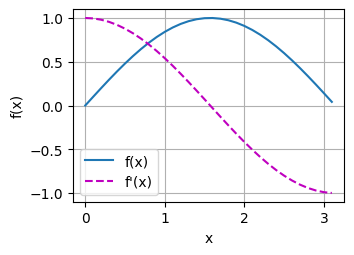

In [36]:
# f(x)=sin(x)，绘制f(x)和f'(x)图像，后者不使用f'(x)=cos(x)
import numpy as np
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
import math



# 作图
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

# 设置图表大小
def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""    
    use_svg_display
    plt.rcParams['figure.figsize'] = figsize

# 设置轴属性
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴属性"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()

# 绘制多条线条
def plot(X,Y=None,xlabel=None,ylabel=None,legend=None,xlim=None,ylim=None,xscale='linear',yscale='linear',fmts=('-','m--','g-.','r:'),figsize=(3.5,2.5),axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []
    set_figsize(figsize)
    axes=axes if axes else plt.gca()
    # 如果X有一个轴，输出True 
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

def f(x):
    return torch.sin(x)

# 计算梯度
x=torch.arange(0, math.pi, 0.1,requires_grad=True)
y=f(x)
y.sum().backward()

# 转为numpy数据
x_numpy=x.detach().numpy()#(0,3,0.1)
y_numpy=y.detach().numpy()#sin(x)
y_prime_numpy=x.grad.numpy()#cos(x)
plot(x_numpy,[y_numpy,y_prime_numpy],'x','f(x)',legend=['f(x)',"f'(x)"])